In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [47]:
img = load_img("data/raw/masks/ds10_pexels-photo-687782.png")

In [49]:
def display_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

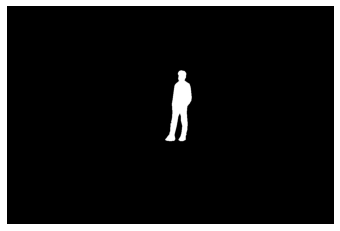

In [50]:
display_image(img)

In [51]:
img2 = load_img("data/raw/images/ds10_pexels-photo-687782.png")

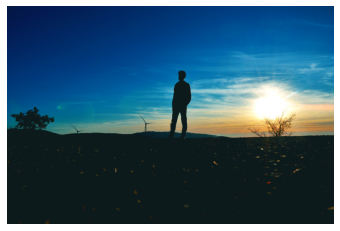

In [52]:
display_image(img2)

### Data Preprocessing

In [53]:
DATA_DIR = "../data/"
BASE_IMAGE_DIR = "data/raw/images/"
BASE_MASK_DIR = "data/raw/masks/"

def get_file(_path):
    for (root, dir, files) in os.walk(_path):
        return files

In [54]:
# Split into train, dev and test dataset
train_images, test_images, train_masks, test_masks = train_test_split(get_file(BASE_IMAGE_DIR), get_file(BASE_MASK_DIR), test_size=0.2)

In [55]:
BATCH_SIZE = 1
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [56]:
def prepare_image(file_path, masks = False):
    img = tf.io.read_file(file_path)
    if masks:
        img = tf.io.decode_image(img, channels=1, dtype=tf.float32)
    else:
        img = tf.io.decode_image(img, channels=3, dtype=tf.float32)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return img

In [57]:
def prepare_dataset(images, masks):
    for idx in range(len(images)):
        image_path = os.path.join(BASE_IMAGE_DIR,train_images[idx])
        img = prepare_image(image_path)

        mask_path = os.path.join(BASE_MASK_DIR,train_masks[idx])
        mask = prepare_image(mask_path, masks=True)
        yield img, mask

In [58]:
train_dataset = tf.data.Dataset.from_generator(
    prepare_dataset, 
    args=[train_images[:200], train_masks[:200]], 
    output_signature = (
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(224,224,1), dtype=tf.float32)
    )
    )

In [59]:
train_dataset = train_dataset.repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

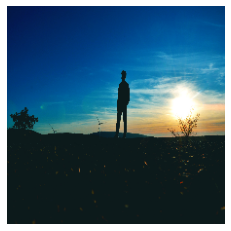

In [60]:
test_img_path = "data/raw/images/ds10_pexels-photo-687782.png"
img = prepare_image(test_img_path)
display_image(img)

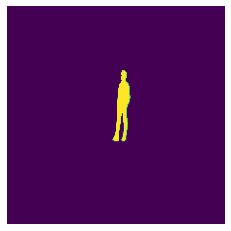

In [61]:
test_mask_path = "data/raw/masks/ds10_pexels-photo-687782.png"
img = prepare_image(test_mask_path, masks=True)
display_image(img)

### Building Model

In [65]:
output_layers = [
                 'block1_conv2', 
                 'block2_conv2', 
                 'block3_conv3', 
                 'block4_conv3', 
                 'block5_conv3',
                 'block5_pool',
                 ]

In [66]:
def vgg_model():
    vgg = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3)
    )
    output = [vgg.get_layer(layer).output for layer in output_layers]

    model = models.Model(inputs = vgg.input, outputs = output)
    model.trainable=False
    return model

In [67]:
model = vgg_model()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [68]:
model.output

[<KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'block4_conv3')>,
 <KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>,
 <KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>]

### Decoding Layer

In [71]:
class CNNBlock(layers.Layer):
    def __init__(self,out_channels, kernel_size=3, padding="SAME"):
        super(CNNBlock,self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, padding=padding)
        self.batchNorm = layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.batchNorm(x, training = training)
        x = tf.nn.relu(x)
        return x

In [72]:
class BlockLayer(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, padding="SAME", no_layers = 3):
        super(BlockLayer,self).__init__()
        self.no_layers = no_layers
        self.cnn1 = CNNBlock(out_channels[0])
        self.cnn2 = CNNBlock(out_channels[1])
        if self.no_layers == 3:
            self.cnn3 = CNNBlock(out_channels[2])
        self.upsampling = layers.UpSampling2D()
        self.add = layers.Add()

    def call(self, input_tensor, training=False, intermediate_op = None):
        x = self.upsampling(input_tensor)
        x = self.add([x,intermediate_op])
        x = self.cnn1(x)
        x = self.cnn2(x)
        if self.no_layers == 3:
            x = self.cnn3(x)
        return x

In [73]:
class SegNet(models.Model):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = vgg_model()
        self.block1 = BlockLayer([512,512,512])
        self.block2 = BlockLayer([256,256,256])
        self.block3 = BlockLayer([128,128,128])
        self.block4 = BlockLayer([64,64], no_layers=2)
        self.block5 = BlockLayer([64,2], no_layers=2)
        self.softmax = layers.Softmax()

    def call(self, input_tensor, training = False):
        x = self.encoder(input_tensor)
        x, a1, a2, a3, a4, a5 = reversed(x)
        x = self.block1(x,intermediate_op = a1)
        x = self.block2(x,intermediate_op = a2)
        x = self.block3(x,intermediate_op = a3)
        x = self.block4(x,intermediate_op = a4)
        x = self.block5(x,intermediate_op = a5)
        x = self.softmax(x)
        return x
    
    def model(self):
        x = layers.Input(shape=(224,224,3))
        return models.Model(inputs=[x],outputs = self.call(x))

In [74]:
net = SegNet()

In [75]:
net.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [76]:
net.model().summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            [(None, 224, 224, 64 14714688    input_9[0][0]                    
__________________________________________________________________________________________________
block_layer_5 (BlockLayer)      (None, 14, 14, 512)  7085568     model_5[0][5]                    
                                                                 model_5[0][4]                    
__________________________________________________________________________________________________
block_layer_6 (BlockLayer)      (None, 28, 28, 256)  2363136     block_layer_5[0][0]        

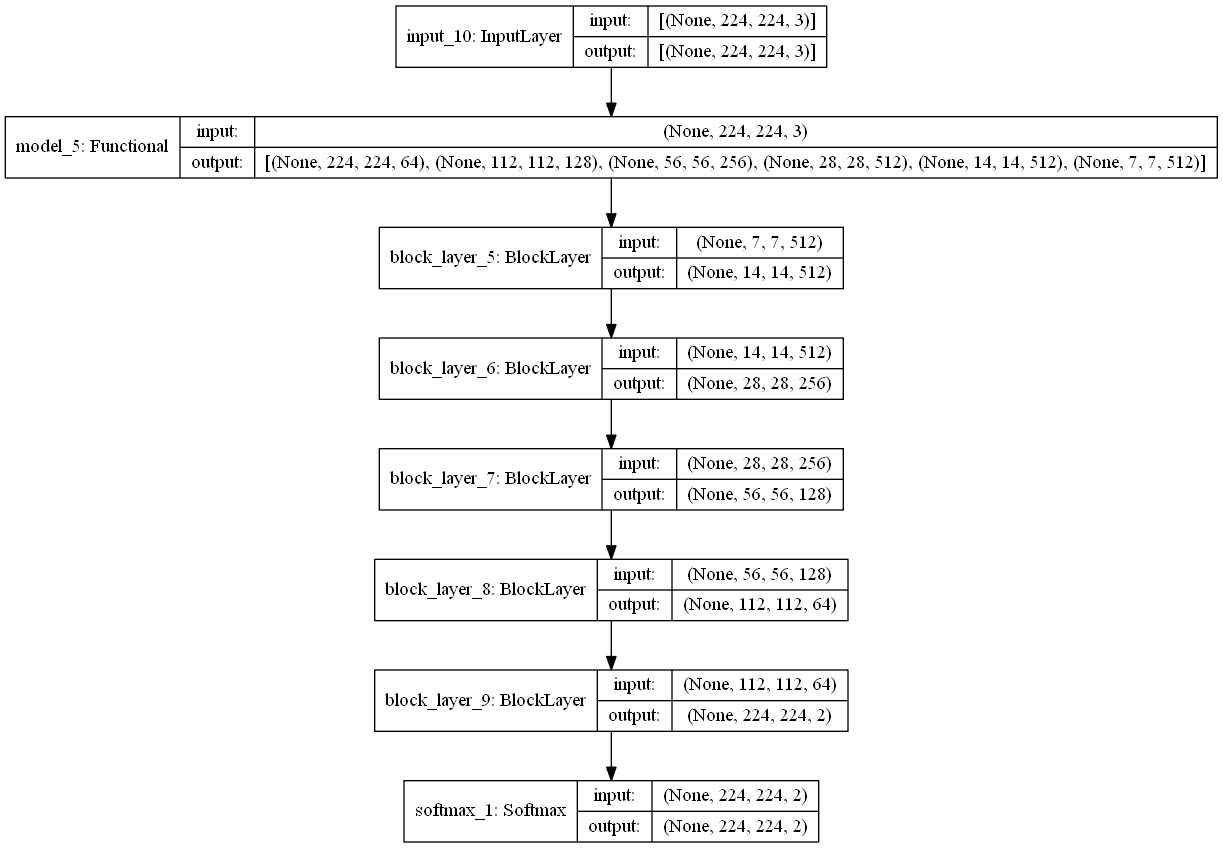

In [77]:
tf.keras.utils.plot_model(net.model(), show_shapes=True)

In [78]:
history = net.fit(train_dataset, steps_per_epoch=50, epochs=8)

Epoch 1/8
50/50 [==============================] - 100s 1s/step - loss: 0.6317 - accuracy: 0.6662
Epoch 2/8
50/50 [==============================] - 58s 1s/step - loss: 0.4975 - accuracy: 0.8152
Epoch 3/8
50/50 [==============================] - 59s 1s/step - loss: 0.5346 - accuracy: 0.7650
Epoch 4/8
50/50 [==============================] - 71s 1s/step - loss: 0.4781 - accuracy: 0.8290
Epoch 5/8
50/50 [==============================] - 70s 1s/step - loss: 0.4893 - accuracy: 0.8174
Epoch 6/8
50/50 [==============================] - 72s 1s/step - loss: 0.4452 - accuracy: 0.8666
Epoch 7/8
50/50 [==============================] - 72s 1s/step - loss: 0.4769 - accuracy: 0.8285
Epoch 8/8
50/50 [==============================] - 67s 1s/step - loss: 0.4359 - accuracy: 0.8714


## Testing

In [79]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [80]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [81]:
def show_predictions(model, image, mask):
    prediction = model.predict(image[tf.newaxis, ...])
    display([image, mask,create_mask(prediction)])

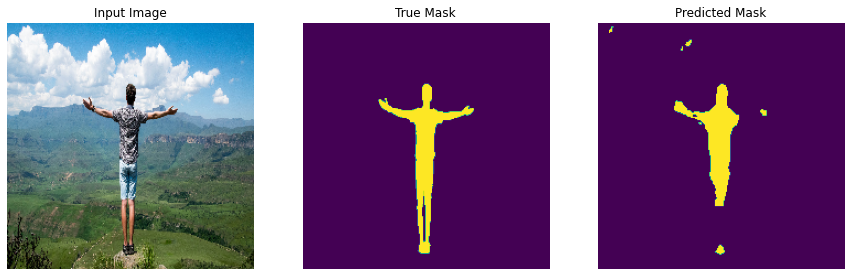

In [83]:
sample_image_path = os.path.join(BASE_IMAGE_DIR, test_images[0])
sample_image = prepare_image(sample_image_path)

sample_mask_path = os.path.join(BASE_MASK_DIR, test_masks[0])
sample_mask = prepare_image(sample_mask_path, masks=True)
show_predictions(net, sample_image, sample_mask)